### Introdução

Para executar os algoritmos, instale o "PythonMip": 

In [ ]:
pip install mip

Agora para visualizar os grafos utilizando o Graphviz:
 - No Windows: Execute o .exe dentro da pasta "GraphViz" para realizar a instalação.
 - No Linux: Execute o seguinte comando em seu terminal: sudo apt install graphviz

Em caso de dúvidas, consultar documentação oficial do [GraphViz](https://graphviz.org) ou [PythonMip](https://www.python-mip.com).

### Mochila 0-1

Dado um conjunto de itens, cada um com peso e valor, escolher um subconjunto que maximize o valor total sem ultrapassar a capacidade da mochila.

$$
    \begin{aligned} 
        \text{max} \quad 
            & \sum_{i \in V}{v_i * x_i}
        \\ 
        \text{s. t} \quad 
            & \quad \sum_{i \in V}{p_i * x_i} \leq m \\
            \\
            & \quad x_i \in \{0,1\} \quad ,\forall i \in V
    \end{aligned}
$$

In [1]:
from mip import Model, xsum, BINARY, OptimizationStatus

# Dados do problema
valores = [10, 13, 18, 31, 7, 15]
pesos = [11, 15, 20, 35, 10, 33]
capacidade = 47
n = len(valores)

# Criação do modelo
m = Model("Mochila 0-1", sense='MAX', solver_name='CBC')

# Definição de variáveis
x = [m.add_var(var_type=BINARY, name=f"x{i}") for i in range(n)]

# Função objetivo
m.objective = xsum(valores[i] * x[i] for i in range(n))

# Restrições
m += xsum(pesos[i] * x[i] for i in range(n)) <= capacidade

# Resolver o modelo
m.optimize()
m.write('files/mochila_0-1.lp')

# Exibir resultado
if m.status == OptimizationStatus.OPTIMAL:
    print(f"\nValor ótimo: {m.objective_value}")
    print("Itens selecionados:")
    for i in range(n):
        if x[i].x >= 0.99:
            print(f" Item {i}: Valor={valores[i]}, Peso={pesos[i]}")
else:
    print("Não foi encontrada uma solução ótima.")


Valor ótimo: 41.0
Itens selecionados:
 Item 0: Valor=10, Peso=11
 Item 3: Valor=31, Peso=35


### Caminho mínimo

Dado um grafo ponderado (sem arestas negativas), escolher o caminho de S à T com menor custo.

$$
	\begin{aligned} 
		\text{min} \quad 
			& \sum_{pq \in A}{w_{pq}f_{pq}}
		\\ 
		\text{s. t} \quad 
			& \sum_{p \in V:(p,q) \in A}{x_{pq}} - \sum_{p \in V:(q,p) \in A}{x_{qp}} = 
			\begin{cases}
				& -1 \quad ,\text{se } q=s \\
				& 1 \quad , \text{se } q=t \\
				& 0 \quad , \text{c.c}
			\end{cases}
			\quad \forall q \in V \\
			& x_{pq} \in \left\{ 0,1 \right\} \quad ,\forall (p,q) \in A
	  \end{aligned}
	$$

In [ ]:
from mip import Model, xsum, BINARY, OptimizationStatus

def caminho_minimo(graph, source, target):
    # Receber variáveis
    vertices = set(i for i, _, _ in graph).union(j for _, j, _ in graph)

    # Criação do modelo
    m = Model("Shortest Path Problem", sense='MIN', solver_name='CBC')

    # Definição de variáveis
    x = {(i,j): m.add_var(var_type=BINARY, name=f"x_{i,j}") for i, j, _ in graph}

    # Função objetivo
    m.objective = xsum(weight * x[i, j] for i, j, weight in graph)

    # Restrições
    for v in vertices:
        inflow = xsum(x[i,v] for i, j, _ in graph if j == v)
        outflow = xsum(x[v,j] for i, j, _ in graph if i == v)

        if v == source:
            m += (inflow - outflow == -1, f"flow_conservation_{v}")
        elif v == target:
            m += (inflow - outflow == 1, f"flow_conservation_{v}")
        else:
            m += (inflow - outflow == 0, f"flow_conservation_{v}")

    # Resolver o modelo
    m.optimize()
    m.write('files/caminho_minimo.lp')

    # Exibir resultado
    if m.status == OptimizationStatus.OPTIMAL:
        selected_edges = [(i,j,w) for i, j, w in graph if x[i,j].x > 0.99]
        return m.objective_value, selected_edges
    else:
        print("Não foi encontrada uma solução ótima.")
        return 0,0

In [13]:
grafo = [
(0,1,15),
(0,3,38),
(0,5,73),
(1,2,8),
(2,0,93),
(2,1,52),
(2,3,22),
(2,4,77),
(2,5,38),
(3,0,27),
(3,4,13),
(4,0,63),
(4,1,96),
(4,2,73),
(4,3,70),
(4,5,14),
(5,1,67),
(5,2,44),
(5,3,69),
(5,4,82)
]

v_otimo, edges = caminho_minimo(grafo, 0, 5)
print("Valor ótimo: ", v_otimo)
print("Arestas escolhidas: ", edges)

Valor ótimo:  61.0
Arestas escolhidas:  [(0, 1, 15), (1, 2, 8), (2, 5, 38)]


##### Ver grafo

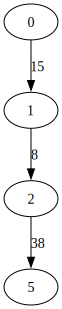

In [14]:
import graphviz
def print_graph_dot(graph):
    dot = graphviz.Digraph(engine="dot")

    nodes = set()
    for u, v, _ in graph:
        nodes.add(str(u))
        nodes.add(str(v))

    for node in nodes:
        dot.node(node, label=node)

    for u, v, w in graph:
        u, v = str(u), str(v)
        label = f"{w}"
        dot.edge(u, v, label=label)

    return dot
    
print_graph_dot(edges)

#### Alocação de Funcionários

Um hospital trabalha com atendimento variiável em demanda durante as 24 horas do dia. As necessidades distrivuem-se segundo a tabela:


| Turno |  Horário   | Enfermeiros necessários |
| :---: | :--------: | :---------------------: |
|   1   | 08h às 12h |           51            |
|   2   | 12h às 16h |           58            |
|   3   | 16h às 20h |           62            |
|   4   | 20h às 24h |           41            |
|   5   | 24h às 04h |           32            |
|   6   | 04h às 08h |           19            |

O horário de trabalho de um enfermeiro é de 8 horas seguidas e só pode ser iniciado no começo de cada turno, isto é, às 8 ou 12 ou 20 ou 24 ou 04 horas. Elabore um modelo PLI que minimize o gasto com a mão-de-obra. Considere que cada enfermeiro recebe R$100,00 por hora de trabalho no período diurno (08 às 20h) e R$125,00 no período noturno (20 às 08h)

In [ ]:
from mip import Model, xsum, BINARY, INTEGER, OptimizationStatus

# Entrada
horas_turno = 4
horas_trabalho = 8
valor_diurno = 100
valor_noturno = 125
turnos = [
  {
    'entrada': 8,
    'saida': 12,
    'enfermeiros': 51,
  },
  {
    'entrada': 12,
    'saida': 16,
    'enfermeiros': 58,
  },
  {
    'entrada': 16,
    'saida': 20,
    'enfermeiros': 62,
  },
  {
    'entrada': 20,
    'saida': 24,
    'enfermeiros': 41,
  },
  {
    'entrada': 24,
    'saida': 4,
    'enfermeiros': 32,
  },
  {
    'entrada': 4,
    'saida': 8,
    'enfermeiros': 19,
  },
]

# Modelagem
m = Model("Horários Enfermeiros", sense='MIN', solver_name='CBC')

#variáveis
x = [m.add_var(var_type=INTEGER) for i in range(len(turnos))] #qtd de enfermeiros que entram no turno i

#função objetivo

m.objective = (((horas_trabalho * valor_diurno) * (x[0] + x[1])) 
               + ((horas_trabalho * valor_noturno) * (x[3] + x[4])) 
               + ((horas_turno * valor_diurno + horas_turno * valor_noturno) * (x[2] + x[5])))

#restrições
for i in range(len(turnos)):
  j = 0 if i == len(turnos)-1 else i+1
  m += x[i] + x[j] >= turnos[j]['enfermeiros']

#resultado
m.optimize()
m.write('files/alocacao.lp')

if m.status == OptimizationStatus.OPTIMAL:
  for i in range(len(turnos)):
    print("X[{}]: {}".format(i, x[i].x))

  print("valor otimo: {}".format(m.objective_value))
else:
  print("Valor ótimo não identificado.")

X[0]: 51.0
X[1]: 34.0
X[2]: 28.0
X[3]: 13.0
X[4]: 19.0
X[5]: 0.0
valor otimo: 125200.0
